In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
#import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from scipy.sparse import find
from sklearn.calibration import CalibratedClassifierCV

C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ram Nikhilesh\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
con = sqlite3.connect(r"C:\Users\Ram Nikhilesh\Desktop\ai class\csv files\td1\database.sqlite")
filtered_data = pd.read_sql_query("""select * from Reviews where Score != 3""",con)
print(filtered_data.shape)
def partition(x):
    if x < 3:
        return 0
    return 1


actualscore=filtered_data['Score']
positivenegative=actualscore.map(partition)
filtered_data['Score']=positivenegative
filtered_data.shape
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,kind='mergsort',na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


    
    
                                                            



(525814, 10)


In [3]:

i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in (final['Text'].values):
    filtered_sentence=[]
    sent=cleanhtml(sent)
        
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            
            if((cleaned_word.isalpha())&(len(cleaned_word) > 2)):
                if((cleaned_word.lower()not in stop)):
                    s=(sno.stem(cleaned_word.lower())).encode('utf-8')
                    
                    filtered_sentence.append(s)
                    if(final['Score'].values)[i]=='positive':
                        all_positive_words.append(s)
                    if(final['Score'].values)[i]=='negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
        
    str1=b" ".join(filtered_sentence)
    final_string.append(str1)
    i+=1

In [4]:
final['cleanedText']=final_string
final['cleanedText']=final['cleanedText']
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [5]:
if os.path.isfile('final.sqlite'):
    conn=sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
    
  

In [6]:
final_text=final['cleanedText']
score=final['Score']
final_100k=final_text[0:100000]
score_100k=score[0:100000]
tscv=TimeSeriesSplit(n_splits=2,max_train_size=70000)
for train,test in tscv.split(final_100k):
    x_train,x_test=final_100k[train],final_100k[test]
    y_train,y_test=score_100k[train],score_100k[test]
    

In [7]:
count_vector=CountVectorizer()
train_70k=count_vector.fit_transform(x_train)
test_30k=count_vector.transform(x_test)


The optimal alpha is 4.


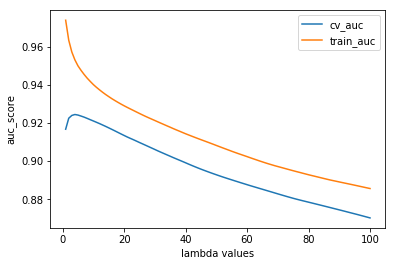

In [16]:
l = list(range(1,101))
cv_scores=[]
auc_scores=[]
for i in l:
    model = LogisticRegression(C=1/i,penalty='l1')
    model.fit(train_70k, y_train)
    predict=model.predict_proba(train_70k)[:,1]
    #print(predict)
    scores = cross_val_score(model, train_70k, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    auc1=metrics.roc_auc_score(y_train, predict)
    auc_scores.append(auc1.mean())
    
mse=[x for x in cv_scores] 
optimal_lambda=l[mse.index(max(mse))]
mse2=[y for y in auc_scores]
optimal_alpha1=l[mse2.index(max(mse2))]
print('\nThe optimal alpha is %d.' % optimal_lambda)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(l, mse,label="cv_auc")
plt.plot(l,mse2,label="train_auc")
plt.xlabel('lambda values')
plt.ylabel('auc_score')
plt.legend()
plt.show()    
    

Non Zero weights: 7566


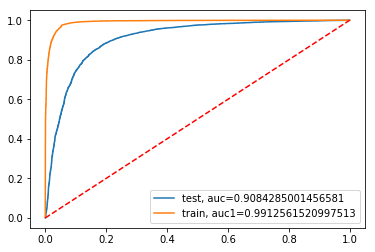

90.60390603906039


In [27]:


model = LogisticRegression(C=4,penalty='l1')
model.fit(train_70k, y_train)
print("Non Zero weights:",np.count_nonzero(model.coef_))
predict=model.predict_proba(test_30k)[:,1]
predict1=model.predict_proba(train_70k)[:,1]
#acc = accuracy_score(y_test, predict, normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

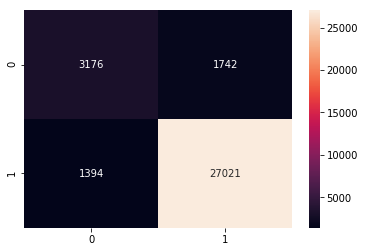

In [56]:
sample=confusion_matrix(y_test,predict)
ax=sns.heatmap(sample,annot=True,fmt="d") 

# The non zero weights are : 7587

# pertubation test

In [64]:

weights1 = find(model.coef_[0])[2]
print(weights1[:50])
print(weights1.size)

[ 2.55200665e-03  1.37544451e-03 -1.48149986e-02  3.09560495e-04
  3.08672273e-04  1.41758180e-06  3.72434273e-04  8.75944831e-03
  1.00270733e-03  4.06123618e-03  1.70223205e-03 -7.45796321e-03
  1.17950263e-03  3.58903538e-03  1.92224101e-03 -2.29057768e-02
  1.58471771e-03 -6.67701226e-03 -6.65916564e-03  4.95837280e-04
 -8.78976318e-04  5.48274054e-04  1.19439304e-02  1.17056199e-03
  6.38953040e-04  1.67363299e-01  2.63043881e-03  1.86189163e-03
 -2.25093387e-02  1.07248212e-03  2.31572297e-03 -8.20998817e-03
  3.21111169e-03  7.30533972e-04  3.14736195e-03 -3.04906721e-03
 -2.39172705e-03  5.27682192e-04 -7.38556721e-02  3.64974852e-03
  4.40076632e-02  3.91110535e-04  5.13991185e-03 -5.95221692e-03
 -7.10033127e-03  6.09489362e-03  2.58695868e-03 -1.95466124e-02
  1.21745137e-03  5.60314102e-03]
17818


In [62]:
X_train_t = train_70k
epsilon = np.random.uniform(low=-0.000001, high=0.000001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [63]:
model = LogisticRegression(C=0.01,penalty='l2')
model.fit(X_train_t, y_train)
predict=model.predict(test_30k)
acc = accuracy_score(y_test, predict, normalize=True) * float(100)
weights2 = find(model.coef_[0])[2]
print(weights2[:50])
print(weights2.size)
for i in range(0,101,10):
    p = np.percentile(weights2, i)
    print(i,p)
print("----------------------------------------")    
for j in np.arange(90,100,1):
    k = np.percentile(weights2,j)
    print(j,"=",k)

[ 2.55200665e-03  1.37544451e-03 -1.48149986e-02  3.09560495e-04
  3.08672273e-04  1.41758180e-06  3.72434273e-04  8.75944831e-03
  1.00270733e-03  4.06123618e-03  1.70223205e-03 -7.45796321e-03
  1.17950263e-03  3.58903538e-03  1.92224101e-03 -2.29057768e-02
  1.58471771e-03 -6.67701226e-03 -6.65916564e-03  4.95837280e-04
 -8.78976318e-04  5.48274054e-04  1.19439304e-02  1.17056199e-03
  6.38953040e-04  1.67363299e-01  2.63043881e-03  1.86189163e-03
 -2.25093387e-02  1.07248212e-03  2.31572297e-03 -8.20998817e-03
  3.21111169e-03  7.30533972e-04  3.14736195e-03 -3.04906721e-03
 -2.39172705e-03  5.27682192e-04 -7.38556721e-02  3.64974852e-03
  4.40076632e-02  3.91110535e-04  5.13991185e-03 -5.95221692e-03
 -7.10033127e-03  6.09489362e-03  2.58695868e-03 -1.95466124e-02
  1.21745137e-03  5.60314102e-03]
17818
0 -0.9152432513188516
10 -0.013625063391488258
20 -0.006007370730104004
30 1.499830133965621e-05
40 0.0006067785711521069
50 0.0011361927649140842
60 0.0016180038730784622
70 0.002

In [65]:
weights_diff = (abs(weights1 - weights2)/weights1) 
print(weights_diff[np.where(weights_diff > 0.05)].size)
b = np.percentile(weights2,98)
#if (model.coef_[0].any() > 0.05):
#    print(count_vector.get_feature_names())


    

0


In [19]:
def positive_negative_words(count_vector, model, n=10):
    feature_names = count_vector.get_feature_names()
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("----------------------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
positive_negative_words(count_vector,model)


			Negative						Positive
----------------------------------------
	-1.1040	disappoint     				0.9079	great          
	-0.7437	return         				0.7816	delici         
	-0.6881	worst          				0.7668	best           
	-0.6710	terribl        				0.6977	perfect        
	-0.6584	horribl        				0.6600	love           
	-0.6463	money          				0.6158	excel          
	-0.6132	wast           				0.5299	favorit        
	-0.5819	aw             				0.5274	nice           
	-0.5763	bad            				0.4740	easi           
	-0.5679	unfortun       				0.4560	wonder         


In [21]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
tf_train70k=tfidf_vect.fit_transform(x_train)
tf_test30k=tfidf_vect.transform(x_test)


The optimal alpha is 1.


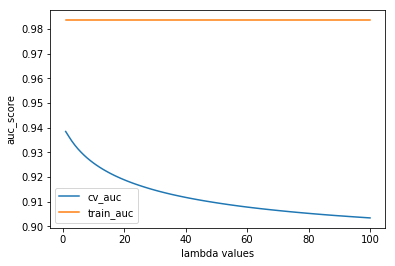

In [23]:
l = list(range(1,101))
cv_scores=[]
auc_scores=[]
for i in l:
    model1 = LogisticRegression(C=1/i)
    model1.fit(tf_train70k, y_train)
    predict=model.predict_proba(tf_train70k)[:,1]
    scores = cross_val_score(model1, tf_train70k, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    auc1=metrics.roc_auc_score(y_train, predict)
    auc_scores.append(auc1.mean())
    
mse=[x for x in cv_scores] 
optimal_alpha=l[mse.index(max(mse))]
mse2=[y for y in auc_scores]
optimal_lambda=l[mse2.index(max(mse2))]
print('\nThe optimal alpha is %d.' % optimal_lambda)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(l, mse,label="cv_auc")
plt.plot(l,mse2,label="train_auc")
plt.xlabel('lambda values')
plt.ylabel('auc_score')
plt.legend()
plt.show()    
    

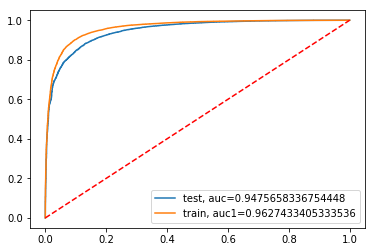

90.60390603906039


In [50]:
model1 = LogisticRegression(C=1,penalty='l2')
model1.fit(tf_train70k, y_train)
predict=model1.predict_proba(tf_test30k)[:,1]
predict2=model1.predict(tf_test30k)
predict1=model1.predict_proba(tf_train70k)[:,1]
#acc = accuracy_score(y_test, predict, normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

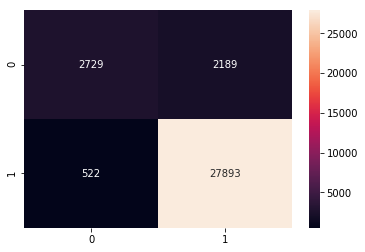

In [51]:
sample=confusion_matrix(y_test,predict2)
ax=sns.heatmap(sample,annot=True,fmt="d") 

# pertubation test

In [82]:
weights1 = find(model1.coef_[0])[2]
print(weights1[:50])
print(weights1.size)

[ 0.0073366   0.00526683 -0.0196798   0.01104175  0.08538033  0.008635
  0.00606302  0.01639231  0.05789718  0.00950741 -0.12800034  0.02206435
 -0.11904431  0.05635992  0.01067399  0.00602635  0.00275338  0.01370583
 -0.00371797  0.02089565  0.08976873  0.09760021  0.02589297  0.04163152
 -0.08715233  0.09546214  0.12817326  0.04388737 -0.12736677 -0.0354015
  0.16814593 -0.09708439  0.01892922  0.02229348  0.00053928 -0.11042428
  0.01399687  0.00144437 -0.26696258  0.00960367 -0.00518525 -0.04663717
 -0.10381724  0.08561338  0.00479007  0.01035832  0.13607672  0.01335904
  0.00238087  0.07042295]
31498


In [83]:
X_train_t = tf_train70k
epsilon = np.random.uniform(low=-0.000001, high=0.000001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [84]:
model1 = LogisticRegression(C=1,penalty='l2')
model1.fit(X_train_t, y_train)
predict=model1.predict(tf_test30k)
acc = accuracy_score(y_test, predict, normalize=True) * float(100)
weights2 = find(model1.coef_[0])[2]
print(weights2[:50])
print(weights2.size)
for i in range(0,101,10):
    p = np.percentile(weights2, i)
    print(i,"=",p)
print("----------------------------------------")    
for j in np.arange(90,101,1):
    k = np.percentile(weights2,j)
    print(j,"=",k)
    
  

[ 0.00733651  0.00526691 -0.01967975  0.01104178  0.08537944  0.0086351
  0.006063    0.01639216  0.05789665  0.00950737 -0.12799921  0.02206434
 -0.11904373  0.05635961  0.01067398  0.00602636  0.00275337  0.01370574
 -0.00371809  0.02089558  0.08976621  0.09759976  0.0258932   0.04163158
 -0.08715165  0.09546183  0.1281735   0.04388652 -0.12736568 -0.03540152
  0.16814497 -0.09708499  0.01892786  0.02229342  0.00053928 -0.11042395
  0.01399697  0.00144438 -0.26696203  0.00960365 -0.00518532 -0.04663739
 -0.10381686  0.08561399  0.00479001  0.01035836  0.1360759   0.0133591
  0.00238093  0.07042196]
31498
0 = -8.001845648244888
10 = -0.1962492234849723
20 = -0.06271672911717407
30 = 0.0018138423293483097
40 = 0.00641755682381541
50 = 0.013217272897040265
60 = 0.023871728090608748
70 = 0.04134077923996278
80 = 0.07591186180874632
90 = 0.17403264972833865
100 = 10.586825357405353
----------------------------------------
90 = 0.17403264972833865
91 = 0.19322946957589254
92 = 0.2171112708

In [85]:
weights_diff = (abs(weights1 - weights2)/weights1) 
print(weights_diff)
print(weights_diff[np.where(weights_diff > 0.97)].size)  
#b = np.percentile(weights2,99)
#print(b)
#if (model1.coef_[0].any() > b):
#    print(count_vector.get_feature_names())


[ 1.26772852e-05  1.58705720e-05 -2.98792226e-06 ...  1.03458712e-05
  5.38312365e-06  8.62655172e-07]
0


In [28]:
def positive_negative_words(tfidf_vect, model1, n=10):
    feature_names = tfidf_vect.get_feature_names()
    coefs_with_fns = sorted(zip(model1.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("----------------------------------------")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
positive_negative_words(tfidf_vect,model)


			Negative						Positive
----------------------------------------
	-1.1040	disappoint     				0.9079	great          
	-0.7437	return         				0.7816	delici         
	-0.6881	worst          				0.7668	best           
	-0.6710	terribl        				0.6977	perfect        
	-0.6584	horribl        				0.6600	love           
	-0.6463	money          				0.6158	excel          
	-0.6132	wast           				0.5299	favorit        
	-0.5819	aw             				0.5274	nice           
	-0.5763	bad            				0.4740	easi           
	-0.5679	unfortun       				0.4560	wonder         


In [33]:
i=0
list_of_sent=[]
for sent in final_100k:
    list_of_sent.append(str(sent.split()))

In [34]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [35]:
sent_vectors = []; 
for sent in tqdm(x_train): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 66667/66667 [00:10<00:00, 6575.79it/s]


In [32]:
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(sent_vectors, y_train)
print(model.best_estimator_)

#print(model.score(tf_test30k, y_test))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [36]:
sent_vectors_test = []; 
for sent in tqdm(x_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|██████████████████████████████████████████████████████████████████████████| 33333/33333 [00:04<00:00, 6689.02it/s]


In [24]:
model = GridSearchCV(LogisticRegression(C=10000), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(sent_vectors, y_train)

print(model.score(sent_vectors_test, y_test) * float(100))

50.0



The optimal lambda is 1.


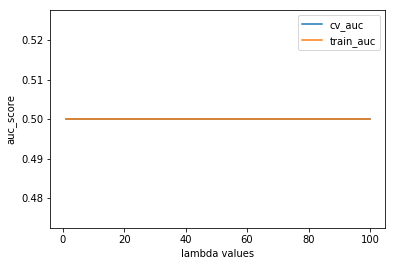

In [37]:
l = list(range(1,101))
cv_scores=[]
auc_scores=[]
for i in l:
    model2 = LogisticRegression(C=i,penalty='l1')
    model2.fit(sent_vectors, y_train)
    predict=model2.predict_proba(sent_vectors)[:,1]
    scores = cross_val_score(model2, sent_vectors, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    auc1=metrics.roc_auc_score(y_train, predict)
    auc_scores.append(auc1.mean())
    
mse=[x for x in cv_scores] 
optimal_lambda=l[mse.index(max(mse))]
mse2=[y for y in auc_scores]
optimal_alpha1=l[mse2.index(max(mse2))]
print('\nThe optimal lambda is %d.' % optimal_lambda)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(l, mse,label="cv_auc")
plt.plot(l,mse2,label="train_auc")
plt.xlabel('lambda values')
plt.ylabel('auc_score')
plt.legend()
plt.show()    
    

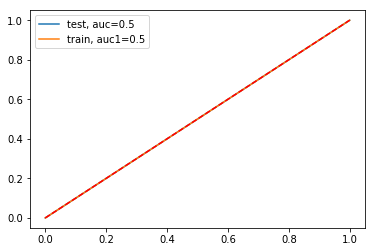

90.60390603906039


In [40]:
model2 = LogisticRegression(C=1,penalty='l2')
model2.fit(sent_vectors, y_train)
predict=model2.predict_proba(sent_vectors_test)[:,1]
predict1=model2.predict_proba(sent_vectors)[:,1]
#acc = accuracy_score(y_test, predict, normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

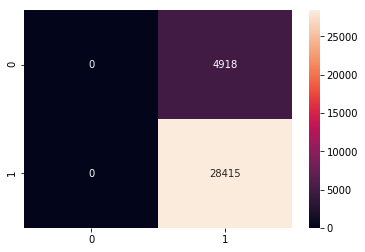

In [37]:
sample=confusion_matrix(y_test,predict)
ax=sns.heatmap(sample,annot=True,fmt="d") 

[]


In [41]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_100k)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))



In [42]:
tfidf_sent_vectors = []
row=0
for sent in tqdm(x_train):
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 66667/66667 [00:10<00:00, 6485.88it/s]


In [46]:
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_sent_vectors, y_train)
print(model.best_estimator_)
#print(model.score(tfidf_sent_vectors, y_train))

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [43]:


tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(x_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 33333/33333 [00:04<00:00, 7019.12it/s]


In [48]:
from sklearn.metrics import accuracy_score

model = GridSearchCV(LogisticRegression(C=0.0001,penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_sent_vectors, y_train)
predict=model.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, predict, normalize=True) * float(100)
print(acc)
#print(model.score(sent_vectors_test1, y_test) * float(100))

85.24585245852458



The optimal alpha is 1.


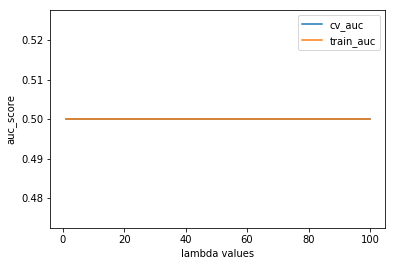

In [44]:
l = list(range(1,101))
cv_scores=[]
auc_scores=[]
for i in l:
    model3 = LogisticRegression(C=1/i)
    model3.fit(tfidf_sent_vectors, y_train)
    predict=model3.predict_proba(tfidf_sent_vectors)[:,1]
    scores = cross_val_score(model3, tfidf_sent_vectors, y_train, cv=4, scoring='roc_auc')
    cv_scores.append(scores.mean())
    auc1=metrics.roc_auc_score(y_train, predict)
    auc_scores.append(auc1.mean())
    
mse=[x for x in cv_scores] 
optimal_lambda=l[mse.index(max(mse))]
mse2=[y for y in auc_scores]
optimal_alpha1=l[mse2.index(max(mse2))]
print('\nThe optimal alpha is %d.' % optimal_lambda)
#print('\nThe optimal alpha for train data  is %d.' % optimal_alpha1)
plt.plot(l, mse,label="cv_auc")
plt.plot(l,mse2,label="train_auc")
plt.xlabel('lambda values')
plt.ylabel('auc_score')
plt.legend()
plt.show()    
    

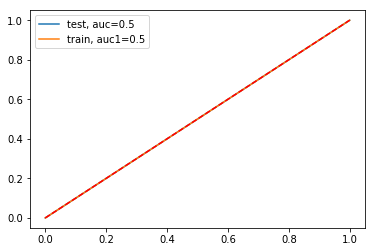

90.60390603906039


In [46]:
model3 = LogisticRegression(C=1,penalty='l2')
model3.fit(tfidf_sent_vectors, y_train)
predict=model3.predict_proba(tfidf_sent_vectors_test)[:,1]
predict1=model3.predict_proba(tfidf_sent_vectors)[:,1]
#acc = accuracy_score(y_test, predict, normalize=True) * float(100)
fpr,tpr,_ = metrics.roc_curve(y_test,predict[:])
fpr1,tpr1,_ = metrics.roc_curve(y_train,predict1[:])
auc= metrics.roc_auc_score(y_test,predict)
auc1= metrics.roc_auc_score(y_train,predict1)
plt.plot(fpr,tpr,label="test, auc="+str(auc))
plt.plot(fpr1,tpr1,label="train, auc1="+str(auc1))
plt.plot([0, 1], [0, 1],'r--')
plt.legend()
plt.show()
print(acc)

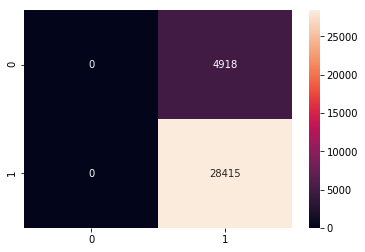

In [43]:
sample=confusion_matrix(y_test,predict)
ax=sns.heatmap(sample,annot=True,fmt="d") 

<table>
    <tr>
        <th>model</th>
        <th>optimal lambda</th>
        <th>test accuracy</th>
        <th>sample size</th>
        <th>test size</th>
        <th>test auc</th>
        <th>train auc</th>
    </tr>
    <tr>
        <td>BOW</td>
        <td>4</td>
        <td>90.60%</td>
        <td>100k</td>
        <td>30k</td>
        <td>0.90</td>
        <td>0.99</td>
            
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>1</td>
        <td>90%</td>
        <td>100k</td>
        <td>30k</td>
        <td>0.94</td>
        <td>0.96</td>
    </tr>
    <tr>
        <td>avg w2v</td>
        <td>1</td>
        <td>90.60%</td>
        <td>100k</td>
        <td>30k</td>
        <td>0.5</td>
        <td>0.5</td>
     </tr>
     <tr>
         <td>tfidf-avg w2v</td>
         <td>1</td>
         <td>90.60%</td>
         <td>100k</td>
         <td>30k</td>
         <td>0.5</td>
         <td>0.5</td>
     </tr>    
    
</table>    

